In [1]:
from pyexpat import model
import requests
import time
import pandas as pd, numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime as dt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold

from pycaret.regression import * 
#from pycaret.time_series import TSForecastingExperiment
from pycaret.utils import enable_colab

enable_colab()


c:\Users\bi18056\OneDrive - Shizuoka University\デスクトップ\jpx-tokyo-stock-exchange-prediction\venv\lib\site-packages\sktime\utils\validation\series.py:21: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
c:\Users\bi18056\OneDrive - Shizuoka University\デスクトップ\jpx-tokyo-stock-exchange-prediction\venv\lib\site-packages\sktime\forecasting\base\_fh.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex)
c:\Users\bi18056\OneDrive - Shizuoka University\デスクトップ\jpx-tokyo-stock-exchange-prediction\venv\lib\site-packages\sktime\forecasting\base\_fh.py:19: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan

Colab mode enabled.


In [24]:
prices = pd.read_csv("./data/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

In [25]:
average = pd.DataFrame(prices.groupby("SecuritiesCode").Target.mean())
def get_avg(_id_):
    return average.loc[_id_]
prices["Avg"] = prices["SecuritiesCode"].apply(get_avg)

In [26]:
prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993,-0.000949
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963,0.000273
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032,-0.000788
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867,0.001423


In [27]:
prices['Date'] = pd.to_datetime(prices['Date'])
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112000 entries, 0 to 111999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   RowId             112000 non-null  object        
 1   Date              112000 non-null  datetime64[ns]
 2   SecuritiesCode    112000 non-null  int64         
 3   Open              111716 non-null  float64       
 4   High              111716 non-null  float64       
 5   Low               111716 non-null  float64       
 6   Close             111716 non-null  float64       
 7   Volume            112000 non-null  int64         
 8   AdjustmentFactor  112000 non-null  float64       
 9   ExpectedDividend  503 non-null     float64       
 10  SupervisionFlag   112000 non-null  bool          
 11  Target            112000 non-null  float64       
 12  Avg               112000 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(8), int64(2), object

### 曜日情報を追加
月曜:0, 火曜:1, 水曜:2, 木曜:3, 金曜:4、土曜:5、日曜:6

In [28]:
prices['weekday'] = prices['Date'].dt.weekday
prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993,-0.000949,0
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963,0.000273,0
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032,-0.000788,0
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867,0.001423,0


### SecuritiesCode == 1301に絞る

In [29]:
prices_1301 = prices[prices.SecuritiesCode == 1301]
prices_1301

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0
2000,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100,1.0,NaN,False,0.009820,0.000968,1
4000,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600,1.0,NaN,False,0.006483,0.000968,2
6000,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700,1.0,NaN,False,-0.006441,0.000968,3
8000,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700,1.0,NaN,False,-0.008104,0.000968,4
10000,20211213_1301,2021-12-13,1301,3110.0,3110.0,3075.0,3085.0,12100,1.0,NaN,False,0.009804,0.000968,0
12000,20211214_1301,2021-12-14,1301,3085.0,3085.0,3055.0,3060.0,10200,1.0,NaN,False,0.011327,0.000968,1
14000,20211215_1301,2021-12-15,1301,3060.0,3095.0,3060.0,3090.0,8500,1.0,NaN,False,-0.009600,0.000968,2
16000,20211216_1301,2021-12-16,1301,3100.0,3135.0,3085.0,3125.0,16900,1.0,NaN,False,-0.024233,0.000968,3
18000,20211217_1301,2021-12-17,1301,3125.0,3140.0,3090.0,3095.0,14600,1.0,NaN,False,0.009934,0.000968,4


### 翌日の始値と本日の終値の差分を追加する

In [30]:
# カラム情報を1行上にずらしたデータフレームを作成する
prices_1301_shift = prices_1301.shift(-1)
prices_1301_shift.head(10)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday
0,20211207_1301,2021-12-07,1301.0,2998.0,3065.0,2990.0,3065.0,19100.0,1.0,NaN,False,0.009820,0.000968,1.0
2000,20211208_1301,2021-12-08,1301.0,3080.0,3080.0,3035.0,3055.0,11600.0,1.0,NaN,False,0.006483,0.000968,2.0
4000,20211209_1301,2021-12-09,1301.0,3050.0,3085.0,3025.0,3085.0,11700.0,1.0,NaN,False,-0.006441,0.000968,3.0
6000,20211210_1301,2021-12-10,1301.0,3100.0,3105.0,3050.0,3105.0,14700.0,1.0,NaN,False,-0.008104,0.000968,4.0
8000,20211213_1301,2021-12-13,1301.0,3110.0,3110.0,3075.0,3085.0,12100.0,1.0,NaN,False,0.009804,0.000968,0.0
10000,20211214_1301,2021-12-14,1301.0,3085.0,3085.0,3055.0,3060.0,10200.0,1.0,NaN,False,0.011327,0.000968,1.0
12000,20211215_1301,2021-12-15,1301.0,3060.0,3095.0,3060.0,3090.0,8500.0,1.0,NaN,False,-0.009600,0.000968,2.0
14000,20211216_1301,2021-12-16,1301.0,3100.0,3135.0,3085.0,3125.0,16900.0,1.0,NaN,False,-0.024233,0.000968,3.0
16000,20211217_1301,2021-12-17,1301.0,3125.0,3140.0,3090.0,3095.0,14600.0,1.0,NaN,False,0.009934,0.000968,4.0
18000,20211220_1301,2021-12-20,1301.0,3095.0,3095.0,3020.0,3020.0,15800.0,1.0,NaN,False,0.003279,0.000968,0.0


In [31]:
prices_1301['delta_Close'] = prices_1301_shift['Close'] - prices['Close']
prices_1301.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday,delta_Close
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0,94.0
2000,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100,1.0,NaN,False,0.009820,0.000968,1,-10.0
4000,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600,1.0,NaN,False,0.006483,0.000968,2,30.0
6000,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700,1.0,NaN,False,-0.006441,0.000968,3,20.0
8000,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700,1.0,NaN,False,-0.008104,0.000968,4,-20.0


### 目的変数Upを追加する(翌日の終値が上がる場合1、それ以外は0とする)、'delta_Close'カラムの削除

In [32]:
prices_1301['Up'] = 0
prices_1301['Up'][prices_1301['delta_Close'] > 0] = 1
prices_1301 = prices_1301.drop('delta_Close', axis=1)
prices_1301.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday,Up
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0,1
2000,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100,1.0,NaN,False,0.009820,0.000968,1,0
4000,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600,1.0,NaN,False,0.006483,0.000968,2,1
6000,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700,1.0,NaN,False,-0.006441,0.000968,3,1
8000,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700,1.0,NaN,False,-0.008104,0.000968,4,0


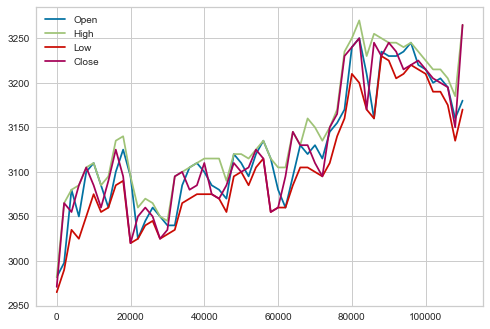

In [34]:
df_1301 = prices_1301[['Open', 'High', 'Low', 'Close']]

#plt.figure(figsize=(16,8))
#plt.plot(np.array(df_1301))
#plt.show()
df_1301.plot(kind='line')
plt.show()

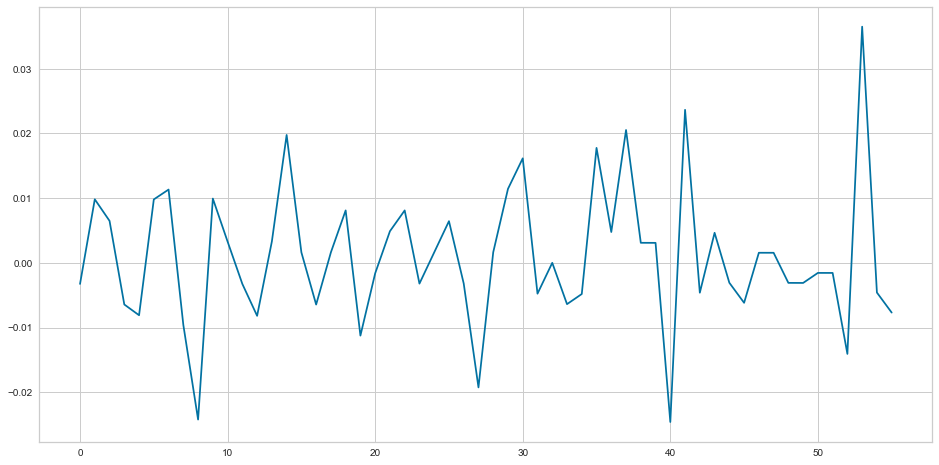

In [35]:
plt.figure(figsize=(16,8))
plt.plot(np.array(prices_1301.Target))

### 株価の変動に影響すると言われている一般的な情報を追加

In [36]:
# 終値の前日比率(今日の終値が前日から何％変動したのかを表す)
# (今日の終値 - 前日の終値) ÷ 前日の終値
prices_1301_shift = prices_1301.shift(1)

prices_1301['Close_ratio'] = (prices_1301['Close'] - prices_1301_shift['Close']) / prices_1301_shift['Close']
prices_1301

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday,Up,Close_ratio
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0,1,NaN
2000,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100,1.0,NaN,False,0.009820,0.000968,1,0,0.031639
4000,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600,1.0,NaN,False,0.006483,0.000968,2,1,-0.003263
6000,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700,1.0,NaN,False,-0.006441,0.000968,3,1,0.009820
8000,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700,1.0,NaN,False,-0.008104,0.000968,4,0,0.006483
10000,20211213_1301,2021-12-13,1301,3110.0,3110.0,3075.0,3085.0,12100,1.0,NaN,False,0.009804,0.000968,0,0,-0.006441
12000,20211214_1301,2021-12-14,1301,3085.0,3085.0,3055.0,3060.0,10200,1.0,NaN,False,0.011327,0.000968,1,1,-0.008104
14000,20211215_1301,2021-12-15,1301,3060.0,3095.0,3060.0,3090.0,8500,1.0,NaN,False,-0.009600,0.000968,2,1,0.009804
16000,20211216_1301,2021-12-16,1301,3100.0,3135.0,3085.0,3125.0,16900,1.0,NaN,False,-0.024233,0.000968,3,0,0.011327
18000,20211217_1301,2021-12-17,1301,3125.0,3140.0,3090.0,3095.0,14600,1.0,NaN,False,0.009934,0.000968,4,0,-0.009600


In [37]:
# 始値と終値の差分'Body'を追加
prices_1301['Body'] = prices_1301['Open'] - prices_1301['Close']
prices_1301.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday,Up,Close_ratio,Body
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0,1,NaN,11.0
2000,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100,1.0,NaN,False,0.009820,0.000968,1,0,0.031639,-67.0
4000,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600,1.0,NaN,False,0.006483,0.000968,2,1,-0.003263,25.0
6000,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700,1.0,NaN,False,-0.006441,0.000968,3,1,0.009820,-35.0
8000,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700,1.0,NaN,False,-0.008104,0.000968,4,0,0.006483,-5.0


### データ分割

In [38]:
from datetime import datetime
from datetime import timedelta
start = datetime(2021,12,6)
prices_1301['weeks'] = (prices_1301['Date'] - start) // timedelta(weeks=1)
prices_1301.head(10)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Avg,weekday,Up,Close_ratio,Body,weeks
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,0.000968,0,1,NaN,11.0,0
2000,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100,1.0,NaN,False,0.009820,0.000968,1,0,0.031639,-67.0,0
4000,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600,1.0,NaN,False,0.006483,0.000968,2,1,-0.003263,25.0,0
6000,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700,1.0,NaN,False,-0.006441,0.000968,3,1,0.009820,-35.0,0
8000,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700,1.0,NaN,False,-0.008104,0.000968,4,0,0.006483,-5.0,0
10000,20211213_1301,2021-12-13,1301,3110.0,3110.0,3075.0,3085.0,12100,1.0,NaN,False,0.009804,0.000968,0,0,-0.006441,25.0,1
12000,20211214_1301,2021-12-14,1301,3085.0,3085.0,3055.0,3060.0,10200,1.0,NaN,False,0.011327,0.000968,1,1,-0.008104,25.0,1
14000,20211215_1301,2021-12-15,1301,3060.0,3095.0,3060.0,3090.0,8500,1.0,NaN,False,-0.009600,0.000968,2,1,0.009804,-30.0,1
16000,20211216_1301,2021-12-16,1301,3100.0,3135.0,3085.0,3125.0,16900,1.0,NaN,False,-0.024233,0.000968,3,0,0.011327,-25.0,1
18000,20211217_1301,2021-12-17,1301,3125.0,3140.0,3090.0,3095.0,14600,1.0,NaN,False,0.009934,0.000968,4,0,-0.009600,30.0,1


In [ ]:
# カラムの並べ替え
prices_1301 = prices_1301[['SecuritiesCode','Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close','Volume']], 
prices_1301

### 標準化

In [3]:
sc = StandardScaler()
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
prices[columns] = sc.fit_transform(prices[columns])

In [4]:
prices.Date = pd.to_datetime(prices.Date)
prices['Date'] = prices['Date'].dt.strftime("%Y%m%d").astype(int)

prices = prices[["Date","SecuritiesCode","Open", "High", "Low", "Close", "Volume", "Avg", "Target"]]

In [5]:
prices.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Avg,Target
0,20211206,1301,0.069915,0.061486,0.076114,0.068435,-0.258004,0.000968,-0.003263
1,20211206,1332,-0.491403,-0.491636,-0.490380,-0.492081,0.332523,-0.000949,-0.008993
2,20211206,1333,-0.074290,-0.076388,-0.068072,-0.071341,-0.206897,0.000273,-0.009963
3,20211206,1375,-0.341562,-0.343084,-0.338807,-0.342657,-0.226466,-0.000788,-0.015032
4,20211206,1376,-0.315962,-0.312213,-0.311399,-0.312773,-0.259183,0.001423,0.002867


In [6]:
code_9990 = prices[prices['SecuritiesCode']==9990]
code_9990_target = code_9990[['Date','Target']]
code_9990_target.head()

,Date,Target
1995,20211206,0.009346
3995,20211207,0.005556
5995,20211208,-0.022099
7995,20211209,-0.011299
9995,20211210,0.000000


In [11]:
prices.Date.unique()

array([20211206, 20211207, 20211208, 20211209, 20211210, 20211213,
       20211214, 20211215, 20211216, 20211217, 20211220, 20211221,
       20211222, 20211223, 20211224, 20211227, 20211228, 20211229,
       20211230, 20220104, 20220105, 20220106, 20220107, 20220111,
       20220112, 20220113, 20220114, 20220117, 20220118, 20220119,
       20220120, 20220121, 20220124, 20220125, 20220126, 20220127,
       20220128, 20220131, 20220201, 20220202, 20220203, 20220204,
       20220207, 20220208, 20220209, 20220210, 20220214, 20220215,
       20220216, 20220217, 20220218, 20220221, 20220222, 20220224,
       20220225, 20220228])

In [ ]:
reg = setup(
    data = prices,
    train_size = 0.7, #学習データと検証データを7:3に分割
    target = 'Target',
    fold_strategy = 'timeseries',
    data_split_shuffle=False,
    #ignore_features = ['SecuritiesCode'],
    #normalize = True,
    #transform_target = True,
    fold = 3,
    #log_data=True, # 学習データと検証データのCSVへの出力
    #silent = True, # 型推定の確認をスキップ
    session_id = 123
)